In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.queries import queries
import ccxt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

In [3]:
start = datetime.timestamp(datetime(2022, 3, 1))
end = datetime.timestamp(datetime(2022, 5, 26))

datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()

pool = '0xceaf7747579696a2f0bb206a14210e3c9e6fb269' # UST
ust = '0xa693b19d2931d498c5b318df961919bb4aee87a5'

swaps_data = datahandler.get_swaps_data(pool, start, end)
lp_data = datahandler.get_lp_data(pool, start, end)
pool_data = datahandler.get_pool_data(pool, start, end)

In [4]:
tokens = set(swaps_data['tokenBought'])
ohlcvs = {}
ignore = set(['0x6c3f90f043a72fa612cbac8115ee7e52bde6e490']) # metapool, ignore LP token for now
tokens -= ignore
for token in tokens:
    ohlcvs[token] = datahandler.get_ohlcv_data(token, start, end)

In [5]:
windows = [timedelta(days=10), timedelta(days=1), timedelta(hours=1), timedelta(minutes=5)]
results = {}
for window in windows:
    markout_col = f'{int(window.total_seconds())}.Markout'
    df = swaps_data.copy()
    df = df[(df['tokenBought'] != list(ignore)[0]) & (df['tokenSold'] != list(ignore)[0])]
    df = MetricsProcessor.markout(df, ohlcvs, window=window, who='lp')
    results[window] = [markout_col, df]

/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['markoutSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate'] + window]['close'], axis=1)
/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:366: S

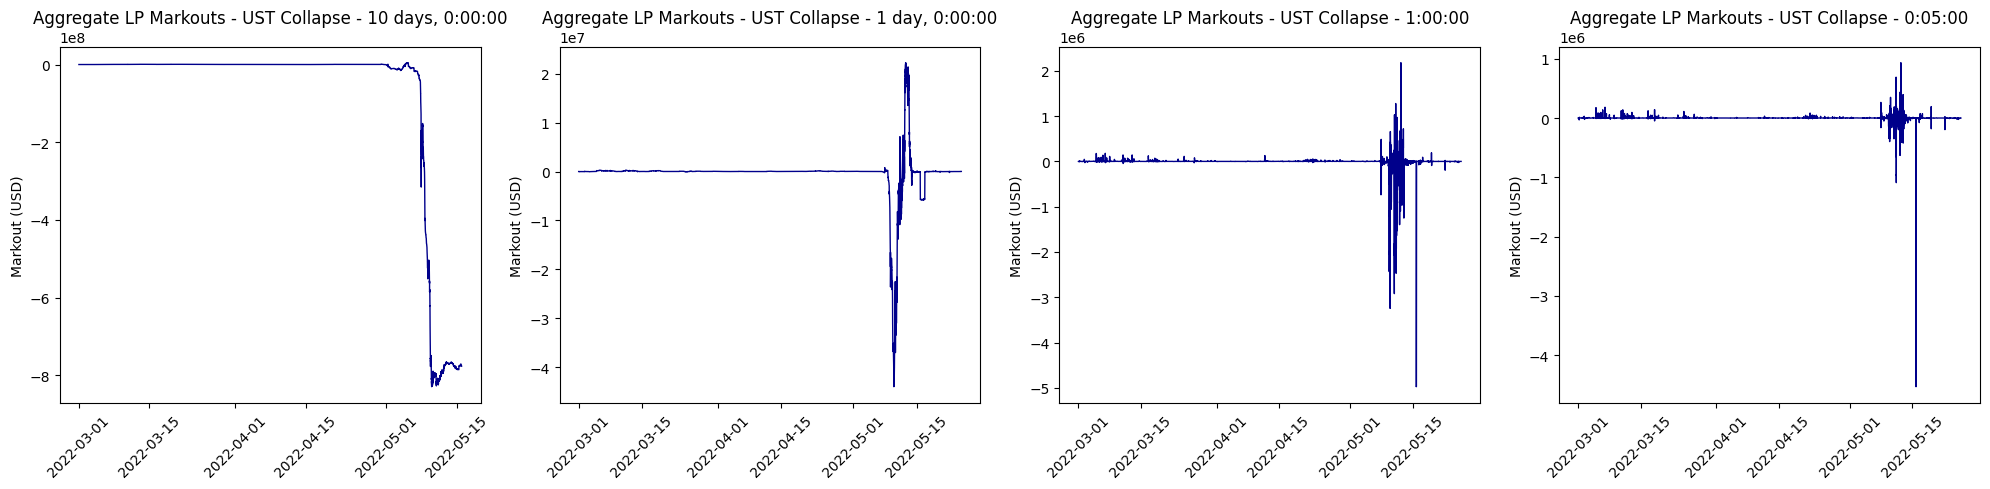

In [6]:
f, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, window in enumerate(results.keys()):
    markout_col, df = results[window]
    ax = axs[i]
    rolling_markouts = df[markout_col].rolling(window).sum()
    # ax2 = ax.twinx()
    ax.plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    # ax2.plot(ohlcvs[ust].index, ohlcvs[ust]['close'], c='darkred', linewidth=1)
    ax.set_title(f'Aggregate LP Markouts - UST Collapse - {window}')
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylabel('Markout (USD)')
    # ax2.set_ylabel('UST Price (USD)')

f.tight_layout()
f.show()

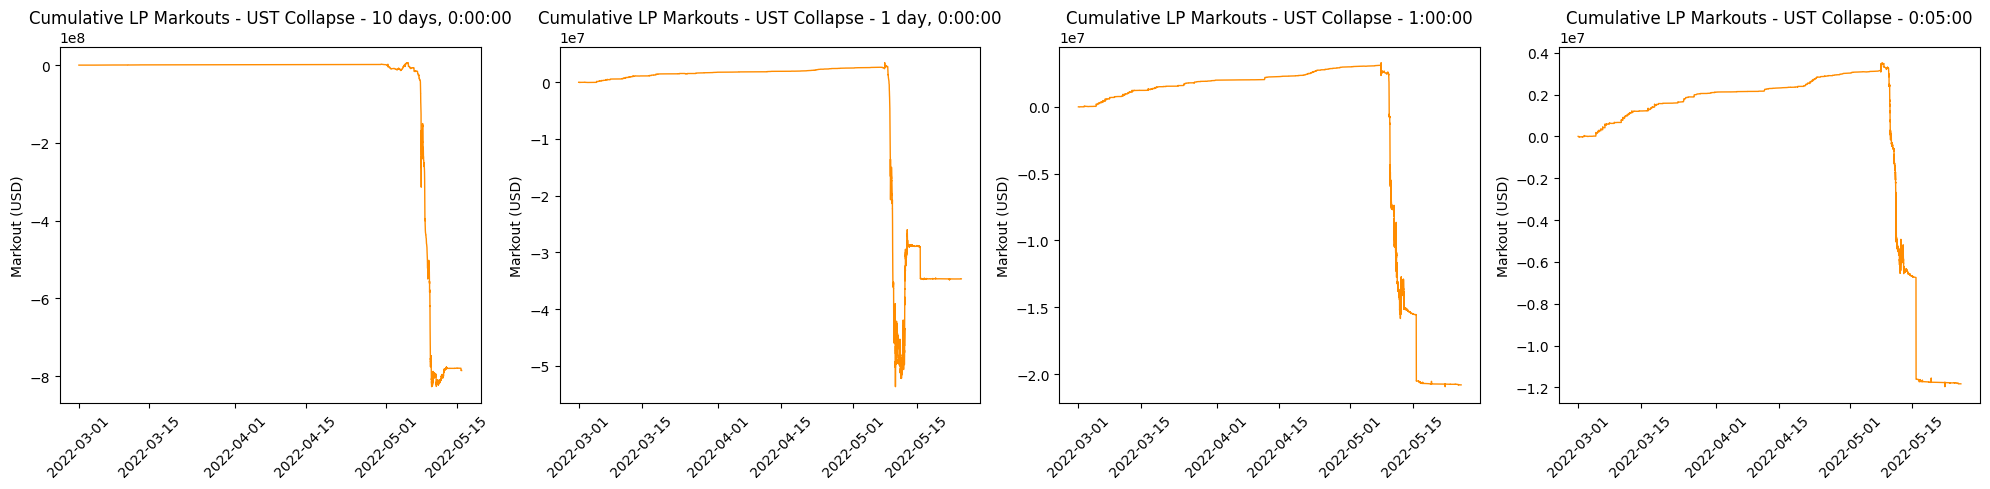

: 

In [7]:
f, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, window in enumerate(results.keys()):
    markout_col, df = results[window]
    ax = axs[i]
    # ax2 = ax.twinx()
    ax.plot(df.index, df[markout_col].cumsum(), c='darkorange', linewidth=1)
    # ax2.plot(ohlcvs[ust].index, ohlcvs[ust]['close'], c='darkred', linewidth=1)
    ax.set_title(f'Cumulative LP Markouts - UST Collapse - {window}')
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylabel('Markout (USD)')
    # ax2.set_ylabel('UST Price (USD)')

f.tight_layout()
f.show()

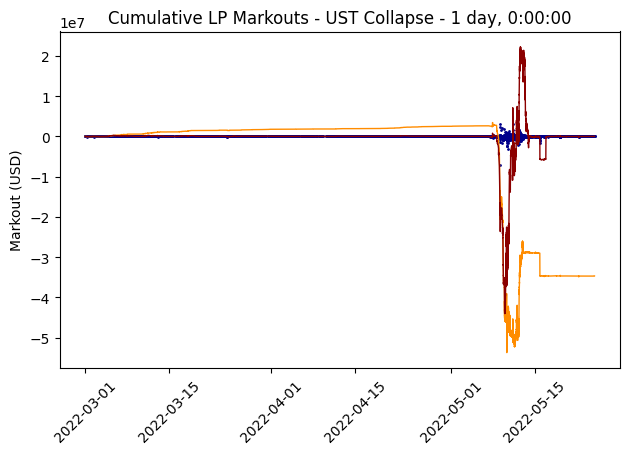

In [32]:
f, ax = plt.subplots()

markout_col, df = results[timedelta(days=1)]
ax.scatter(df.index, df[markout_col], c='darkblue', s=1)
ax.plot(df.index, df[markout_col].cumsum(), c='darkorange', linewidth=1)
ax.set_title(f'Cumulative LP Markouts - UST Collapse - {window}')
rolling_markouts = df[markout_col].rolling(window).sum()
ax.plot(rolling_markouts.index, rolling_markouts, c='darkred', linewidth=1)
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')

f.tight_layout()
f.show()

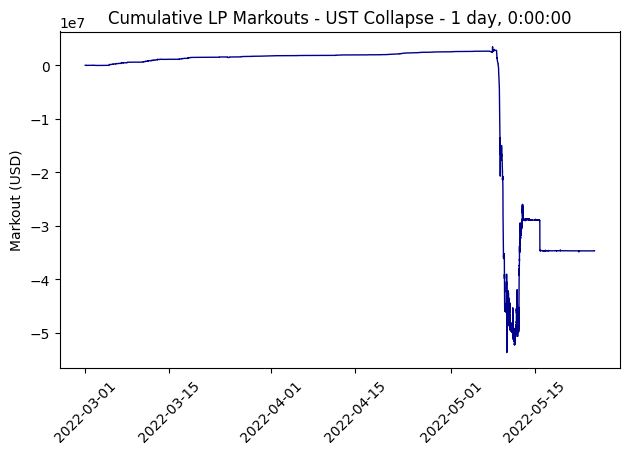

In [22]:
f, ax = plt.subplots()

markout_col, df = results[timedelta(days=1)]
# ax2 = ax.twinx()
ax.plot(df.index, df[markout_col].cumsum(), c='darkblue', linewidth=1)
# ax2.plot(ohlcvs[ust].index, ohlcvs[ust]['close'], c='darkred', linewidth=1)
ax.set_title(f'Cumulative LP Markouts - UST Collapse - {window}')
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')
# ax2.set_ylabel('UST Price (USD)')

f.tight_layout()
f.show()

In [17]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)
pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data)
pool_metrics.head()

,UST.netSwapFlow,UST.netLPFlow,UST.absSwapFlow,UST.absLPFlow,3Crv.netSwapFlow,3Crv.netLPFlow,3Crv.absSwapFlow,3Crv.absLPFlow
timestamp,,,,,,,,
2022-03-01 00:14:00,245420.750313,0.0,245420.750313,0.0,0.0,0,0.0,0
2022-03-01 00:15:00,0.000000,0.0,0.000000,0.0,0.0,0,0.0,0
2022-03-01 00:16:00,0.000000,0.0,0.000000,0.0,0.0,0,0.0,0
2022-03-01 00:17:00,0.000000,0.0,0.000000,0.0,0.0,0,0.0,0
2022-03-01 00:18:00,0.000000,0.0,0.000000,0.0,0.0,0,0.0,0


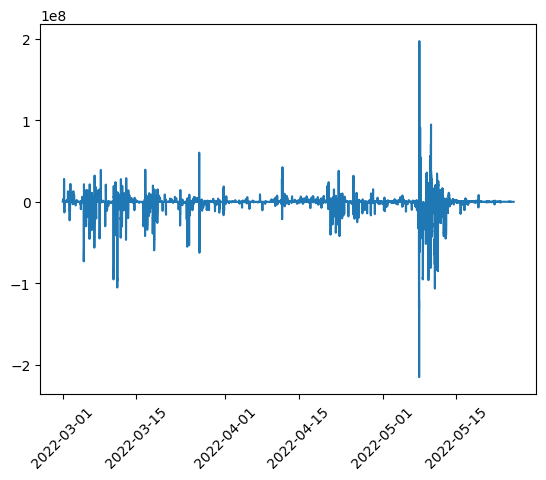

In [24]:
f, ax = plt.subplots()

roller = pool_metrics['UST.netSwapFlow'].rolling('1h').sum()
ax.plot(roller.index, roller)
ax.tick_params(axis="x", rotation=45)

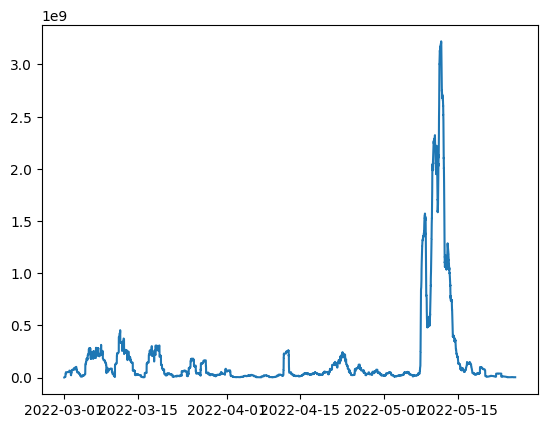

In [21]:
f, ax = plt.subplots()

roller = pool_metrics['UST.absSwapFlow'].rolling('1d').sum()
ax.plot(roller.index, roller)